In [3]:
%pip install torchviz

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.8 MB/s eta 0:00:00a 0:00:010m
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm import tqdm
from torchviz import make_dot
import matplotlib.pyplot as plt

In [66]:
transform = transforms.ToTensor() # определяет трансформацию, которая будет применена к изображениям в датасете
# преобразует изображение в формат тензора(пиксели принимают значения от 0 до 1)
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# загрузка тренировчоной части датасета в папку ./data, если нет локально, то из интернета, с применением уже известной трансформации
test_dataset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download=True, transform=transform)
# загрузка тест части датасета в папку ./data, если нет локально, то из интернета, с применением уже известной трансформации


In [67]:
batch_size = 64 # количество образцов, подаваемых за одну итерацию
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
# передает обучающий набор данных, в соответствии с размером батча *без перемешивания* - исправлено на *с перемешиванием*
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# передает тестовый набор данных, в соответствии с размером батча *без перемешивания* - исправлено на *с перемешиванием*

In [68]:
train_item = next(iter(train_loader)) # извлекает первый батч из лоадера для трен данных
test_item = next(iter(test_loader)) # извлекает первый батч из лоадера для тест данных
len(train_item), len(test_item), train_item[0].shape, train_item[1].shape

(2, 2, torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [69]:
class NNModel(nn.Module):
    def __init__(self,
                 layers_size = [49, 32, 16, 10],
                 # dropout_prob = 1.0 - все нейроны будут отключены
                 dropout_prob = 0.7

                 ):
        super().__init__()
        #self.conv = nn.Conv2d(1, 1, kernel_size = 1, stride = 4)
        self.conv = nn.Conv2d(1, 1, kernel_size = 1, stride = 1)
        #
        self.layers = nn.ModuleList([nn.Linear(layers_size[i], layers_size[i+1]) for i in range(len(layers_size)-1)]) # положил в nn.ModuleList
        self.norm = nn.ModuleList([nn.BatchNorm1d(inp_size, affine  = False) for inp_size in layers_size[1:-1]]) # положил в nn.ModuleList
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, batch):
        bs = batch.shape[0]
        batch = self.conv(batch).reshape(bs, -1)

        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                batch = self.dropout(self.relu(self.norm[i](layer(batch))))
            else:
                batch = layer(batch)
        return batch

    def print_net(self):
        print(self.conv)
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                print(layer)
                print(self.norm[i])
                print(self.relu)
                print(self.dropout)
            else:
                print(layer)

        return
    
### Входные данные сначала проходят через сверточный слой, который минимально изменяет их структуру.
### Далее данные преобразуются в векторы и проходят через последовательность полносвязных слоев с нормализацией, активацией ReLU и Dropout.
### На выходе мы получаем вектор с 10 значениями (в данном случае вероятности классов для задачи классификации).

In [70]:
mlp  = NNModel(dropout_prob = 0.1, layers_size = [784, 32, 16, 10]) # 28*28, нейроны двух скрытых слоев, слой 10 нейронов на выходе

predictions = mlp(train_item[0])
make_dot(predictions, params=dict(mlp.named_parameters()))
mlp.print_net()

# экземпляр нейронной сети NNModel, 
# выполняет прямое распространение (forward pass) на одном батче данных  и выводит структуру сети

Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
Linear(in_features=784, out_features=32, bias=True)
BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=32, out_features=16, bias=True)
BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=16, out_features=10, bias=True)


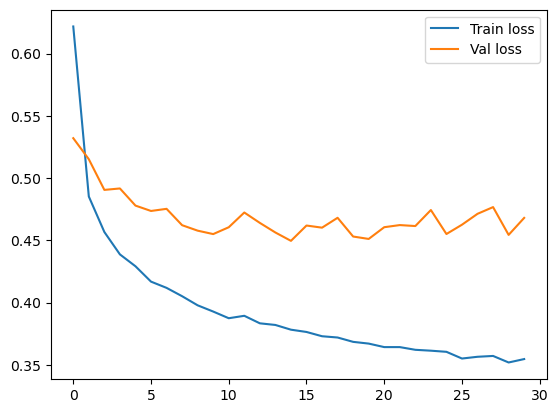

In [71]:
num_epochs = 30 # уменьшил количество эпох
DEBUG = False
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr =  0.01)

logger = { 'train':[], 'eval' :[] }

for epoch in range(num_epochs):

    epoch_stat = []

    # train part

    mlp.train()
    for batch in train_loader: # поменял на train_loader

        images, labels = batch
        images, labels = images.float(), labels.long()
        images.requires_grad = True # автоматическое вычисление градиентов для входных данных для обратного распостранения ошибки

        optimizer.zero_grad() # обнуляем накопленные градиенты

        predictions = mlp(images)
        loss = ce_loss(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_stat.append(loss.item())

    if DEBUG: print(f"train loss value = {np.mean(epoch_stat)}")
    logger['train'].append(np.mean(epoch_stat))


    # eval part
    with torch.no_grad():

        eval_stat = []
        for batch in test_loader: # поменял на test_loader

            images, labels = batch
            images, labels = images.float(), labels.long()

            predictions = mlp(images)
            loss = ce_loss(predictions, labels)

            eval_stat.append(loss.item())
    if DEBUG: print(f"eval loss value = {np.mean(eval_stat)}")
    logger['eval'].append(np.mean(eval_stat))

plt.plot(logger['train'], label='Train loss' )
plt.plot(logger['eval'], label='Val loss')
plt.legend()
plt.show()

### обучение и оценка нейронной сети, тренировочная и оценочная часть + логгирование значений потерь для каждого этапа

In [37]:
mlp

NNModel(
  (conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
  (norm): ModuleList(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# pytorch_total_params = sum(p.numel() for p in mlp.parameters())
# pytorch_total_params